<a href="https://colab.research.google.com/github/Sauptik23/Identification-of-medicinal-plants/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installations

In [ ]:
!pip install -q kaggle
!pip install -q opendatasets
!pip install split-folders

##Imports

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import opendatasets as od
from numpy.ma.core import true_divide
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
from keras.api._v2.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom,RandomHeight,RandomWidth
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.efficientnet import EfficientNetB3,EfficientNetB5,EfficientNetB2
from keras.layers import Flatten, Dense,Dropout,Input,Activation
from keras.layers import GlobalAveragePooling2D
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/aryashah2k/indian-medicinal-leaves-dataset"
    )

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sauptikmukherjee
Your Kaggle Key: ··········


100%|██████████| 9.00G/9.00G [01:34<00:00, 102MB/s]


#Inspecting the dataset

In [ ]:

for dirpath,dirnames,filenames in os.walk("Indian Medicinal Leaves Image Datasets"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Indian Medicinal Leaves Image Datasets'.
There are 40 directories and 0 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset'.
There are 0 directories and 146 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Raktachandini'.
There are 0 directories and 152 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Nagadali'.
There are 0 directories and 165 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Hibiscus'.
There are 0 directories and 146 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Wood_sorel'.
There are 0 directories and 146 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Gauva'.
There are 0 directories and 187 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Jasmine'.
There are 0 directories and 150 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/

#View Random Image

In [ ]:
#view an image


def view_random_image(target_dir,target_class):
  target_folder=target_dir+target_class
  random_image=random.sample(os.listdir(target_folder),1)
  img=mpimg.imread(target_folder +"/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(img.shape)
  return img

#Creating train-test-valid split

In [ ]:
path_leaves="/content/Medicinal Leaf dataset"
splitfolders.ratio(path_leaves,seed=1337, output="(Splitted)Indian Medicininal Leaves Dataset", ratio=(0.6, 0.2, 0.2))

Copying files: 6904 files [01:26, 79.87 files/s]


#Storing class names in class_names_leaves

In [ ]:
import pathlib
import numpy as np
data_dir_leaves = pathlib.Path("/content/(Splitted)Indian Medicininal Leaves Dataset/train") # turn our training path into a Python path
class_names_leaves = np.array(sorted([item.name for item in data_dir_leaves.glob('*')])) # created a list of class_names from the subdirectories
print(class_names_leaves)

['Aloevera' 'Amla' 'Amruthaballi' 'Arali' 'Astma_weed' 'Badipala'
 'Balloon_Vine' 'Bamboo' 'Beans' 'Betel' 'Bhrami' 'Bringaraja'
 'Caricature' 'Castor' 'Catharanthus' 'Chakte' 'Chilly'
 'Citron lime (herelikai)' 'Coffee' 'Common rue(naagdalli)' 'Coriender'
 'Curry' 'Doddpathre' 'Drumstick' 'Ekka' 'Eucalyptus' 'Ganigale' 'Ganike'
 'Gasagase' 'Ginger' 'Globe Amarnath' 'Guava' 'Henna' 'Hibiscus' 'Honge'
 'Insulin' 'Jackfruit' 'Jasmine' 'Kambajala' 'Kasambruga' 'Kohlrabi'
 'Lantana' 'Lemon' 'Lemongrass' 'Malabar_Nut' 'Malabar_Spinach' 'Mango'
 'Marigold' 'Mint' 'Neem' 'Nelavembu' 'Nerale' 'Nooni' 'Onion' 'Padri'
 'Palak(Spinach)' 'Papaya' 'Parijatha' 'Pea' 'Pepper' 'Pomoegranate'
 'Pumpkin' 'Raddish' 'Rose' 'Sampige' 'Sapota' 'Seethaashoka' 'Seethapala'
 'Spinach1' 'Tamarind' 'Taro' 'Tecoma' 'Thumbe' 'Tomato' 'Tulsi'
 'Turmeric' 'ashoka' 'camphor' 'kamakasturi' 'kepala']


#Mounting the Google drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
len(class_names_leaves)

80

#Model Checkpoint

In [ ]:
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0)

##Turning on mixed prescision

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

##Training the model without data augmentation

##Creating batches of images

In [ ]:
train_dir="/content/(Splitted)Indian Medicininal Leaves Dataset/train"
test_dir="/content/(Splitted)Indian Medicininal Leaves Dataset/test"
valid_dir="/content/(Splitted)Indian Medicininal Leaves Dataset/val"
IMAGE_SIZE=(224,224)
BATCH_SIZE=32

In [ ]:
train_data_leaves=image_dataset_from_directory(directory=train_dir,
                                               image_size=IMAGE_SIZE,
                                               label_mode="categorical",
                                               batch_size=BATCH_SIZE)
test_data_leaves=image_dataset_from_directory(directory=test_dir,
                                               image_size=IMAGE_SIZE,
                                               label_mode="categorical",
                                               batch_size=BATCH_SIZE)
val_data_leaves=image_dataset_from_directory(directory=valid_dir,
                                               image_size=IMAGE_SIZE,
                                               label_mode="categorical",
                                               batch_size=BATCH_SIZE)

Found 4106 files belonging to 80 classes.
Found 1448 files belonging to 80 classes.
Found 1346 files belonging to 80 classes.


##Creating the model

In [ ]:

def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")


  x = base_model(inputs, training=False)
  x = GlobalAveragePooling2D(name="pooling_layer")(x)
  x = Dense(len(class_names_leaves))(x)
  outputs = Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  resnet50_model = tf.keras.Model(inputs, outputs)
  return resnet50_model

resnet50_model1=create_model()
# Compile the model
resnet50_model1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
resnet50_model_history= resnet50_model1.fit(train_data_leaves,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_leaves),
                                            validation_data=test_data_leaves,
                                            validation_steps=int(0.15 * len(test_data_leaves)),
                                            callbacks=model_checkpoint)

Epoch 1/5
129/129 [==============================] - 154s 1s/step - loss: 2.5044 - accuracy: 0.4323 - val_loss: 1.2882 - val_accuracy: 0.6771
Epoch 2/5
129/129 [==============================] - 139s 1s/step - loss: 0.7302 - accuracy: 0.8427 - val_loss: 0.8735 - val_accuracy: 0.7708
Epoch 3/5
129/129 [==============================] - 140s 1s/step - loss: 0.3828 - accuracy: 0.9408 - val_loss: 0.7869 - val_accuracy: 0.7917
Epoch 4/5
129/129 [==============================] - 139s 1s/step - loss: 0.2323 - accuracy: 0.9720 - val_loss: 0.6566 - val_accuracy: 0.8229
Epoch 5/5
129/129 [==============================] - 145s 1s/step - loss: 0.1534 - accuracy: 0.9883 - val_loss: 0.5318 - val_accuracy: 0.8698


##Augmenting the data

In [ ]:
data_augmentation=Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomHeight(0.2),
    RandomZoom(0.2),
    RandomWidth(0.2),
])

##Creating the model with the augmented data

In [ ]:
def create_model_augmented_data():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")

  x=data_augmentation(inputs)
  x = base_model(inputs, training=False)
  x = GlobalAveragePooling2D(name="pooling_layer")(x)
  x=Dropout(0.2)(x)
  x = Dense(len(class_names_leaves))(x)
  outputs = Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  resnet50_model = tf.keras.Model(inputs, outputs)
  return resnet50_model


In [ ]:
model2=create_model_augmented_data()

##Loading the weights

In [ ]:
model2.load_weights(checkpoint_path)

##Compile

In [ ]:
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

##Fit

In [ ]:
model2_history=model2.fit(train_data_leaves,
                          epochs=5,
                          steps_per_epoch=len(train_data_leaves),
                          validation_data=test_data_leaves,
                          validation_steps=len(val_data_leaves),
                          callbacks=model_checkpoint)

Epoch 1/5
129/129 [==============================] - 164s 1s/step - loss: 0.1778 - accuracy: 0.9735 - val_loss: 0.5911 - val_accuracy: 0.8387
Epoch 2/5
129/129 [==============================] - 181s 1s/step - loss: 0.1344 - accuracy: 0.9825 - val_loss: 0.5580 - val_accuracy: 0.8445
Epoch 3/5
129/129 [==============================] - 183s 1s/step - loss: 0.1069 - accuracy: 0.9873 - val_loss: 0.5164 - val_accuracy: 0.8641
Epoch 4/5
129/129 [==============================] - 224s 2s/step - loss: 0.0832 - accuracy: 0.9910 - val_loss: 0.5179 - val_accuracy: 0.8605
Epoch 5/5
129/129 [==============================] - 219s 2s/step - loss: 0.0667 - accuracy: 0.9951 - val_loss: 0.5035 - val_accuracy: 0.8685


##Loss Curves

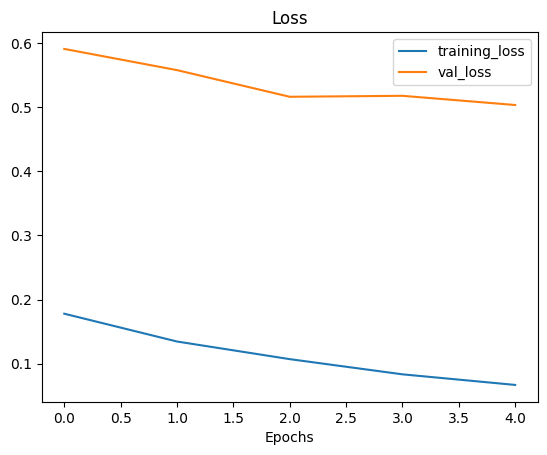

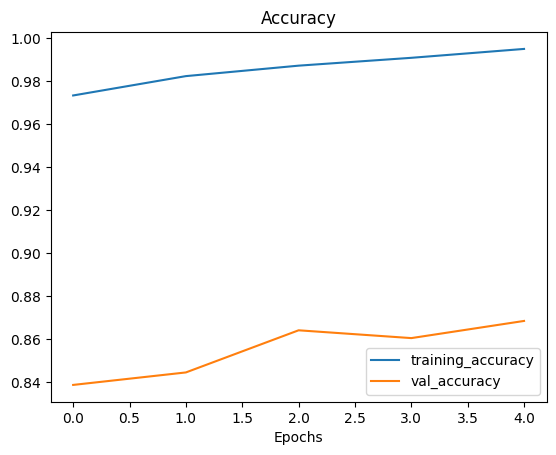

In [ ]:
plot_loss_curves(model2_history)

##Saving the file using pickle

In [ ]:
import pickle
model_pkl="model98.pkl"
with open(model_pkl,"wb") as file:
  pickle.dump(model2,file)

##Loading the file

In [ ]:
with open(model_pkl,"rb") as file:
  model=pickle.load(file)

In [ ]:
model.evaluate(test_data_leaves)

46/46 [==============================] - 39s 673ms/step - loss: 0.5075 - accuracy: 0.8667


[0.5075256824493408, 0.8667126893997192]

In [ ]:
model2.evaluate(test_data_leaves)

46/46 [==============================] - 40s 655ms/step - loss: 0.5075 - accuracy: 0.8667


[0.5075275301933289, 0.8667126893997192]

##Saving the model in Gdrive

In [ ]:
path="/content/gdrive/MyDrive/model86"
model.save(path)